In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

import torch
import torch.nn.functional as F
from torch import nn, Tensor

# Importing our existing flow funcs
import os
import sys
from pathlib import Path
# Add parent directory to sys.path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
# Import modules
from analytic_flow_funcs import compute_linear_velocity_batch, forward_euler_integration_analytic_linear

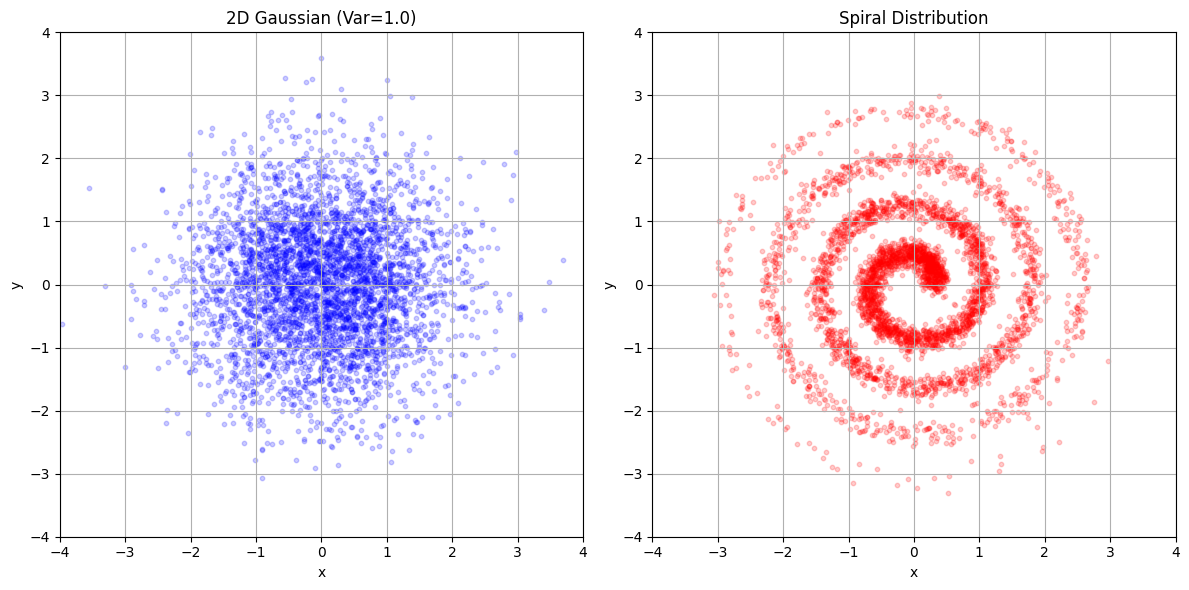

torch.Size([4000, 2])


In [2]:
def generate_gaussian(n_dims, num_points, noise_std=1.0):
    """
    Generate an n-dimensional independent Gaussian distribution with specified variance.
    """
    return torch.randn(num_points, n_dims) * (noise_std)

def generate_spiral(num_points, noise_std=0.1, n_turns=4, radius_scale=0.5):
    """
    Generate a 2D spiral distribution where points far along the spiral are less likely.
    
    Args:
        num_points: Number of points to generate
        noise_std: Standard deviation of Gaussian noise added to the spiral
        n_turns: Number of full rotations in the spiral (default: 4)
        radius_scale: Scaling factor for the spiral radius (default: 0.5)
        
    Returns:
        torch.Tensor of shape (num_points, 2)
    """
    max_angle = 2 * np.pi * n_turns
    t = torch.linspace(0, max_angle, num_points)
    # Make points further along the spiral less likely by scaling t with a random factor
    t = t * torch.pow(torch.rand(num_points), 0.5)
    
    # Spiral equation with adjustable radius
    r = radius_scale * (t / max_angle + 0.1)  # The +0.1 ensures the spiral doesn't start at 0
    x = r * torch.cos(t)
    y = r * torch.sin(t)
    
    # Add Gaussian noise
    x += torch.randn(num_points) * noise_std
    y += torch.randn(num_points) * noise_std
    return torch.stack([x, y], dim=1)

# Generate samples with different variances
sigma_i = 1.0
num_points = 4000
gaussian_samples1 = generate_gaussian(n_dims=2, num_points=num_points, noise_std=sigma_i)  # Default variance
spiral_samples = generate_spiral(num_points=num_points, noise_std = 0.1, n_turns = 4, radius_scale = 3)

# Initial and final distributions
initial_dist = gaussian_samples1
final_dist = spiral_samples

x_lim_params = (-4, 4)
y_lim_params = (-4, 4)

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot Gaussian distribution with variance=1.0
plt.subplot(1, 2, 1)
plt.scatter(initial_dist[:, 0].numpy(), initial_dist[:, 1].numpy(), 
            c='blue', alpha=0.2, s=10)
plt.title('2D Gaussian (Var=1.0)')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_lim_params)  
plt.ylim(y_lim_params)  
plt.grid(True)

# Plot Spiral distribution
plt.subplot(1, 2, 2)
plt.scatter(final_dist[:, 0].numpy(), final_dist[:, 1].numpy(), 
            c='red', alpha=0.2, s=10)
plt.title('Spiral Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_lim_params)  
plt.ylim(y_lim_params)  
plt.grid(True)

plt.tight_layout()
plt.show()

print (final_dist.shape)

Functions I want to test

In [3]:
def compute_linear_velocity_batch(
    current_points: torch.Tensor,  # Shape [M, *dims] (e.g. [M,d] or [M,d1,d2,...])
    data: torch.Tensor,            # Shape [N, *dims]
    t: float,
    sigma_i: float,
    coefficients=None
) -> torch.Tensor:
    """
    Generalized version handling arbitrary auxiliary dimensions.
    """
    alpha = 1 - t
    beta = t
    
    # Reshape tensors for broadcasting [M, N, *dims]
    current_expanded = current_points.unsqueeze(1)  # [M, 1, *dims]
    data_scaled = data * beta                      # [N, *dims]
    data_expanded = data_scaled.unsqueeze(0)       # [1, N, *dims]
    
    # Compute squared distances [M, N], summing over the other dimensions
    diff = current_expanded - data_expanded  # [M, N, *dims]
    squared_dist = torch.sum(diff**2, dim=tuple(range(2, diff.dim())))  # [M, N]
    
    # Compute softmax weights [M, N]
    logits = -0.5 * squared_dist / (alpha**2 * sigma_i)
    if coefficients is not None:
        logits = logits + torch.log(coefficients).unsqueeze(0)
    weights = torch.softmax(logits, dim=1)  # [M, N]
    
    # Compute expected value of output points over softmax probs [M, *dims]
    # Einsum 'mn,n...->m...' = sum over n for each m and auxiliary dimensions
    weighted_sum = torch.einsum('mn,n...->m...', weights, data)  # [M, *dims]
    
    # Compute final velocities [M, *dims]
    velocities = (weighted_sum - current_points) / alpha
    return velocities

def compute_linear_velocity_batch_time(
    current_points: torch.Tensor,  # Shape [M, *dims]
    data: torch.Tensor,            # Shape [N, *dims]
    t: torch.Tensor,               # Shape [M] (batch of time values)
    sigma_i: float,
    coefficients=None              # Shape [N] (weights of the data points)
) -> torch.Tensor:
    """
    Computes velocity for batched inputs with time as tensor.    
    Returns: velocities: [M, *dims] computed velocities
    """
    # Reshape time for broadcasting [M, 1, *dims], [M, *dims]

    # When do we actually need time?
    # We need to multiply targets by beta when it's being scaled before subtracting from data
    # So it needs to be [M, 1, *dims] to broadcast to [1, N, *dims]
    # We subtract data, sum over dimensions and end up with [M, N]
    # Then we multiply the resulting sum by 1/alpha**2
    # These are turned into softmax weights, and the target distribution takes an expectation value
    # The expectation value weighs each N data point by its corresponding softmax and adds it
    # This yields a [M, *dim] vector describing how each of the current points moves
    # Then this has to be multiplied by time again, this time broadcast to [M, *dims]
    # So we need to broadcast time from [M] to [M, 1, *dims], [M, 1], and [M, *dims]

    # Reshaping time values for broadcasting
    t_reshaped = t.view(-1, *([1]*(data.dim())))  # [M, 1, *dims]
    t_reshaped_2 = t.view(-1, *([1]*(data.dim() - 1)))  # [M, *dims]
    t_reshaped_3 = t[:, None]  # [M, 1]
    
    beta = t_reshaped       # [M, 1, *dims]
    alpha = 1 - t_reshaped  # [M, 1, *dims]
    alpha2 = 1 - t_reshaped_2 # [M, *dims]
    alpha3 = 1 - t_reshaped_3 # [M, 1]

    data_exp = data.unsqueeze(0)                    # Reshape data to [1, N, *dims]
    data_scaled = beta * data_exp               # [M, 1, *dims] * [1, N, *dims] => [M, N, *dims] 
    current_expanded = current_points.unsqueeze(1)  # [M, 1, *dims]
    
    # Compute distances
    diff = current_expanded - data_scaled           # [M, N, *dims]
    squared_dist = torch.sum(diff**2, dim=tuple(range(2, diff.dim())))  # [M, N]

    # Compute softmax weights [M, N]
    logits = -0.5 * squared_dist/(alpha3**2 * sigma_i)
    if coefficients is not None:
        logits = logits + torch.log(coefficients).unsqueeze(0)
    weights = torch.softmax(logits, dim=1)  # [M, N]
    
    # Compute weighted sum [M, *dims]
    weighted_sum = torch.einsum('mn,n...->m...', weights, data)  # [M, *dims]
    
    # Compute velocities [M, *dims]
    velocities = (weighted_sum - current_points) / alpha2
    return velocities

def compute_linear_velocity_batch2(
    current_points: torch.Tensor,  # Shape [M, *dims]
    data: torch.Tensor,            # Shape [N, *dims]
    t: float,                      
    sigma_i: float,
    coefficients=None              # Shape [N] (weights of the data points)
) -> torch.Tensor:
    """
    Computes velocity for batched inputs with time as a fixed scalar for all entries.    
    Returns: velocities: [M, *dims] computed velocities
    """
    M = current_points.shape[0]
    tensor_t = torch.full((M,), t, dtype=torch.float32, device=current_points.device)
    velocities = compute_linear_velocity_batch_time(current_points = current_points,  # Shape [M, *dims]
                                                    data = data,            # Shape [N, *dims]
                                                    t = tensor_t,               # Shape [M] (batch of time values)
                                                    sigma_i = sigma_i,
                                                    coefficients=coefficients              # Shape [N] (weights of the data points)
                                                    )
    return velocities

In [4]:
# Random t value between 0 and 1
t = 0.5
print ("t value ", t)
M = gaussian_samples1.shape[0]
t_tensor = torch.full((M,), t, dtype=torch.float32, device=gaussian_samples1.device)
print (t_tensor.shape)
sigma_i = 1.0

# Compute velocities with both methods
v1 = compute_linear_velocity_batch(
    current_points=gaussian_samples1,
    data=spiral_samples,
    t=t,
    sigma_i=sigma_i
)

v2 = compute_linear_velocity_batch2(
    current_points=gaussian_samples1,
    data=spiral_samples,
    t=t,
    sigma_i=sigma_i
)

# Compare results
print(f"Using t = {t:.4f}, sigma_i = {sigma_i}")
print(f"Max absolute difference: {torch.max(torch.abs(v1 - v2)):.6f}")
print(f"Mean absolute difference: {torch.mean(torch.abs(v1 - v2)):.6f}")
print(f"Relative difference norm: {torch.norm(v1 - v2) / torch.norm(v1):.6f}")


t value  0.5
torch.Size([4000])
Using t = 0.5000, sigma_i = 1.0
Max absolute difference: 0.000000
Mean absolute difference: 0.000000
Relative difference norm: 0.000000


In [5]:

def debug_compare(current_points, data, t, sigma_i=1.0):
    # Convert scalar t to tensor for batch_time version
    M = current_points.shape[0]
    t_tensor = torch.full((M,), t, device=current_points.device)
    
    # --- Original Function ---
    alpha = 1 - t
    beta = t

    print (t)
    current_expanded = current_points.unsqueeze(1)
    data_scaled = data * beta
    data_expanded = data_scaled.unsqueeze(0)
    
    diff_orig = current_expanded - data_expanded
    print ("diff orig ", diff_orig)
    
    # --- Batch-Time Function ---
    t_reshaped = t_tensor.view(-1, *([1]*(data.dim())))
    alpha_bt = 1 - t_reshaped
    beta_bt = t_reshaped

    print (t_reshaped)
    
    data_exp = data.unsqueeze(0)
    data_scaled_bt = beta_bt * data_exp
    current_expanded_bt = current_points.unsqueeze(1)
    
    diff_bt = current_expanded_bt - data_scaled_bt
    diff_with_times = diff_bt / (alpha_bt**2 * sigma_i)
    print ("new diff ", diff_with_times)

debug_compare(gaussian_samples1, spiral_samples, t, sigma_i=1.0)

0.5
diff orig  tensor([[[-2.5423e+00, -3.6721e-01],
         [-2.5566e+00, -4.4576e-01],
         [-2.5811e+00, -4.0471e-01],
         ...,
         [-3.6887e+00, -9.1289e-02],
         [-1.2000e+00,  2.4644e-01],
         [-1.1310e+00, -9.1286e-01]],

        [[-5.7385e-01,  2.6868e-03],
         [-5.8819e-01, -7.5868e-02],
         [-6.1268e-01, -3.4818e-02],
         ...,
         [-1.7203e+00,  2.7860e-01],
         [ 7.6841e-01,  6.1633e-01],
         [ 8.3750e-01, -5.4297e-01]],

        [[-3.2640e-01,  2.3666e-01],
         [-3.4074e-01,  1.5810e-01],
         [-3.6523e-01,  1.9915e-01],
         ...,
         [-1.4728e+00,  5.1257e-01],
         [ 1.0159e+00,  8.5030e-01],
         [ 1.0849e+00, -3.0900e-01]],

        ...,

        [[ 1.4867e-01,  9.3739e-01],
         [ 1.3433e-01,  8.5883e-01],
         [ 1.0983e-01,  8.9988e-01],
         ...,
         [-9.9776e-01,  1.2133e+00],
         [ 1.4909e+00,  1.5510e+00],
         [ 1.5600e+00,  3.9173e-01]],

        [[-4.6123e-

In [6]:
def test_compute_linear_velocity_batch(
    current_points: torch.Tensor,  # Shape [M, *dims] (e.g. [M,d] or [M,d1,d2,...])
    data: torch.Tensor,            # Shape [N, *dims]
    t: float,
    sigma_i: float,
    coefficients=None
) -> torch.Tensor:
    """
    Generalized version handling arbitrary auxiliary dimensions.
    """
    alpha = 1 - t
    beta = t
    
    # Reshape tensors for broadcasting [M, N, *dims]
    current_expanded = current_points.unsqueeze(1)  # [M, 1, *dims]
    data_scaled = data * beta                      # [N, *dims]
    data_expanded = data_scaled.unsqueeze(0)       # [1, N, *dims]
    
    # Compute squared distances [M, N], summing over the other dimensions
    diff = current_expanded - data_expanded  # [M, N, *dims]
    squared_dist = torch.sum(diff**2, dim=tuple(range(2, diff.dim())))  # [M, N]
    print ("Original function ", squared_dist.shape)


def test_compute_linear_velocity_batch_time(
    current_points: torch.Tensor,  # Shape [M, *dims]
    data: torch.Tensor,            # Shape [N, *dims]
    t: torch.Tensor,               # Shape [M] (batch of time values)
    sigma_i: float,
    coefficients=None              # Shape [N] (weights of the data points)
) -> torch.Tensor:
    """
    Computes velocity for batched inputs with time as tensor.    
    Returns: velocities: [M, *dims] computed velocities
    """
    # Reshape time for two types of broadcasting [M, 1, *dims], [M, *dims]
    t_reshaped = t.view(-1, *([1]*(data.dim())))  # [M, 1, *dims]
    t_reshaped_2 = t.view(-1, *([1]*(data.dim() - 1)))  # [M, *dims]
    alpha = 1 - t_reshaped  # [M, 1, *dims]
    beta = t_reshaped       # [M, 1, *dims]
    alpha2 = 1 - t_reshaped_2 # [M, *dims]
    
    data_exp = data.unsqueeze(0)                    # Reshape data to [1, N, *dims]
    data_scaled = beta * data_exp               # [M, 1, *dims] * [1, N, *dims] => [M, N, *dims] 
    current_expanded = current_points.unsqueeze(1)  # [M, 1, *dims]
    
    # Compute distances
    diff = current_expanded - data_scaled           # [M, N, *dims]
    diff_with_times = diff/(alpha**2 * sigma_i)     # [M, N, *dims] (now with the alpha values multiplied in.
    squared_dist = torch.sum(diff_with_times**2, dim=tuple(range(2, diff.dim())))  # [M, N]
    print ("New function ", squared_dist.shape)


def test_compute_linear_velocity_batch2(
    current_points: torch.Tensor,  # Shape [M, *dims]
    data: torch.Tensor,            # Shape [N, *dims]
    t: float,                      
    sigma_i: float,
    coefficients=None              # Shape [N] (weights of the data points)
) -> torch.Tensor:
    """
    Computes velocity for batched inputs with time as a fixed scalar for all entries.    
    Returns: velocities: [M, *dims] computed velocities
    """
    M = current_points.shape[0]
    tensor_t = torch.full((M,), t, dtype=torch.float32, device=current_points.device)
    test_compute_linear_velocity_batch_time(current_points = current_points,  # Shape [M, *dims]
                                                    data = data,            # Shape [N, *dims]
                                                    t = tensor_t,               # Shape [M] (batch of time values)
                                                    sigma_i = sigma_i,
                                                    coefficients=coefficients              # Shape [N] (weights of the data points)
                                                    )


In [7]:
# Random t value between 0 and 1
t = 0.5
print ("t value ", t)
M = gaussian_samples1.shape[0]
t_tensor = torch.full((M,), t, dtype=torch.float32, device=gaussian_samples1.device)
print (t_tensor.shape)
sigma_i = 1.0

# Compute velocities with both methods
test_compute_linear_velocity_batch(
    current_points=gaussian_samples1,
    data=spiral_samples,
    t=t,
    sigma_i=sigma_i
)

test_compute_linear_velocity_batch2(
    current_points=gaussian_samples1,
    data=spiral_samples,
    t=t,
    sigma_i=sigma_i
)

t value  0.5
torch.Size([4000])
Original function  torch.Size([4000, 4000])
New function  torch.Size([4000, 4000])
